In [26]:
# from google.colab import drive
# drive.mount('/content/drive')

In [27]:
# pip install catboost

In [28]:
import os
import joblib
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings("ignore")

In [29]:
df = pd.read_csv('cleaned_dataset.csv')

In [30]:
df.drop(columns=['service_failure_count'], inplace=True)

In [31]:
X = df.drop(columns=['churn'])
y = df['churn']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
save_dir = 'churn/models'
os.makedirs(save_dir, exist_ok=True)

In [35]:
joblib.dump(scaler, f'{save_dir}/standard_scaler.pkl')

['churn/models/standard_scaler.pkl']

In [36]:
models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Linear SVM": LinearSVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=7, random_state=42),
    "Random Forest": RandomForestClassifier(max_depth=7, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
}

In [37]:
results = []

for name, model in tqdm(models.items(), desc="Evaluating Models"):
    if name in ["Logistic Regression", "Linear SVM"]:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test

    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    y_train_pred = model.predict(X_tr)

    try:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_te)[:, 1]
        elif hasattr(model, "decision_function"):
            y_prob = model.decision_function(X_te)
        else:
            y_prob = None
    except:
        y_prob = None

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    acc_gap = abs(train_acc - test_acc)

    results.append({
        "Model": name,
        "Train Accuracy (%)": round(train_acc * 100, 2),
        "Test Accuracy (%)": round(test_acc * 100, 2),
        "Accuracy Gap (%)": round(acc_gap * 100, 2),
        "Precision (%)": round(precision * 100, 2),
        "Recall (%)": round(recall * 100, 2),
        "F1 Score (%)": round(f1 * 100, 2),
        "ROC AUC": round(roc_auc, 6) if roc_auc is not None else None,
        "y_pred": y_pred,
        "y_prob": y_prob
    })

    filename = f"{name.replace(' ', '_').lower()}_model.pkl"
    joblib.dump(model, os.path.join(save_dir, filename))

Evaluating Models: 100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


In [38]:
results_df = pd.DataFrame(results)
results_df.iloc[:, :-2]

,Model,Train Accuracy (%),Test Accuracy (%),Accuracy Gap (%),Precision (%),Recall (%),F1 Score (%),ROC AUC
0,Naive Bayes,92.07,92.10,0.03,94.44,91.19,92.78,0.943626
1,Logistic Regression,92.37,92.52,0.15,95.49,90.86,93.12,0.955278
2,Linear SVM,91.93,92.09,0.15,95.44,90.10,92.69,0.954391
3,Decision Tree,93.97,93.95,0.02,95.70,93.33,94.50,0.964499
4,Random Forest,93.80,93.90,0.10,95.55,93.40,94.46,0.970465
5,AdaBoost,93.34,93.46,0.12,95.14,93.02,94.07,0.961157
6,XGBoost,95.30,94.39,0.90,95.72,94.14,94.93,0.980799
7,CatBoost,94.94,94.44,0.51,95.71,94.23,94.97,0.981142


In [39]:
results_df.to_excel('model_performance_results.xlsx', index=False)

In [40]:
metrics = [
    "Train Accuracy (%)",
    "Test Accuracy (%)",
    "Accuracy Gap (%)",
    "Precision (%)",
    "Recall (%)",
    "F1 Score (%)",
    "ROC AUC"
]

In [41]:
for metric in metrics:
    best_model = results_df.loc[results_df[metric].idxmax()]
    value = best_model[metric]

    if "%" in metric:
        formatted_value = f"{value:.2f}%"
    else:
        formatted_value = f"{value:.3f}"

    print(f"Best model for {metric}: {best_model['Model']} with value {formatted_value}")

Best model for Train Accuracy (%): XGBoost with value 95.30%
Best model for Test Accuracy (%): CatBoost with value 94.44%
Best model for Accuracy Gap (%): XGBoost with value 0.90%
Best model for Precision (%): XGBoost with value 95.72%
Best model for Recall (%): CatBoost with value 94.23%
Best model for F1 Score (%): CatBoost with value 94.97%
Best model for ROC AUC: CatBoost with value 0.981


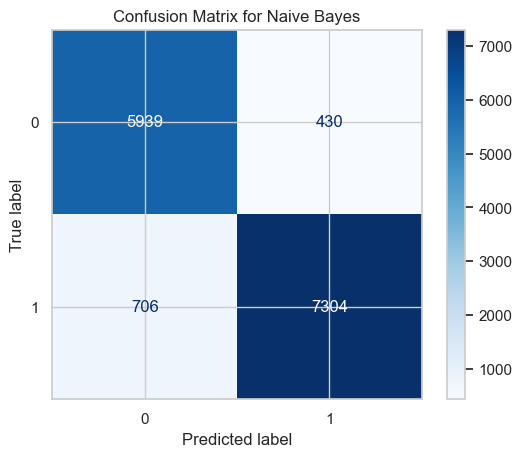

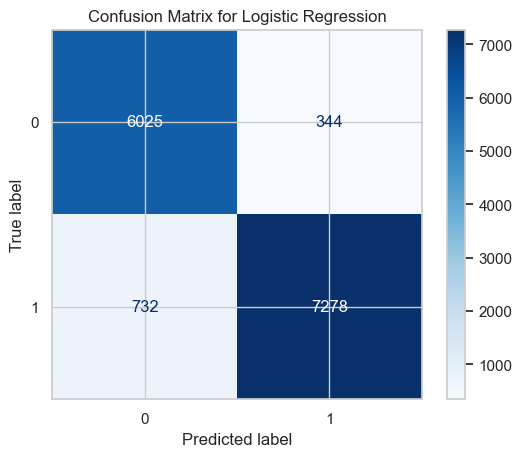

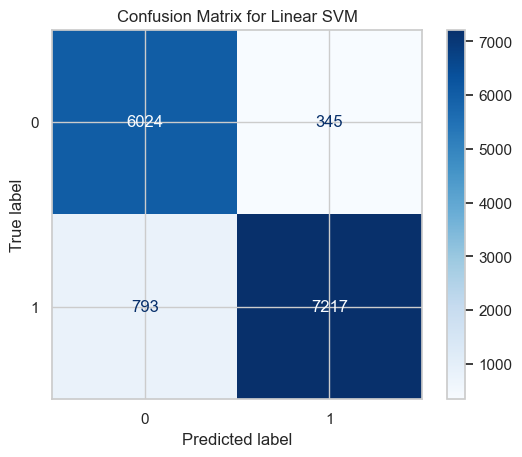

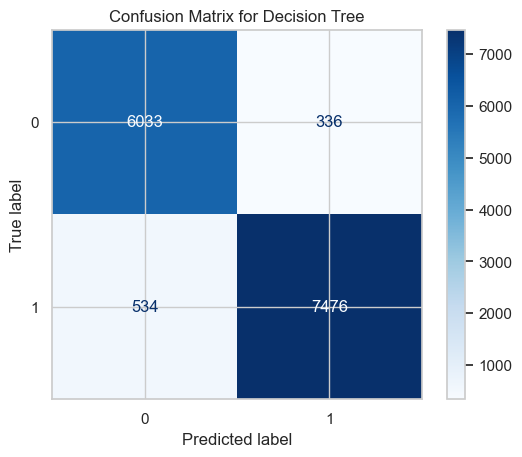

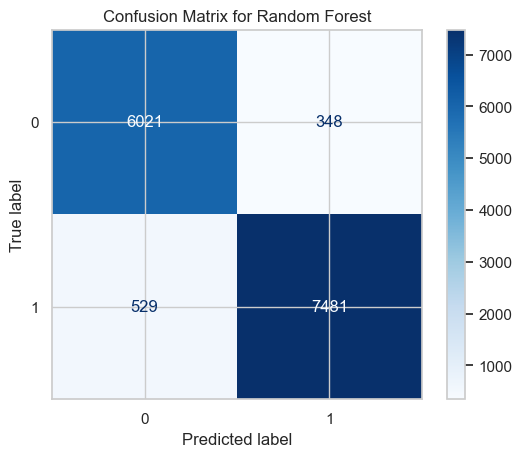

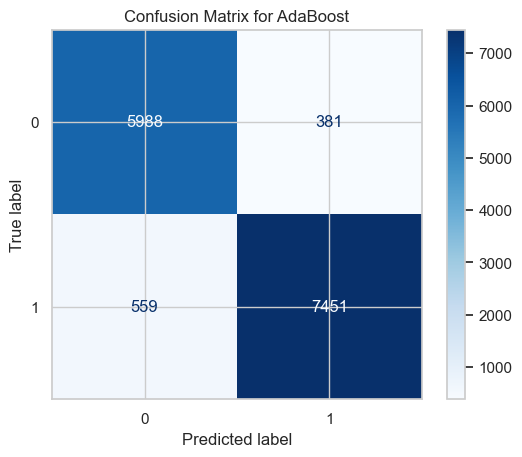

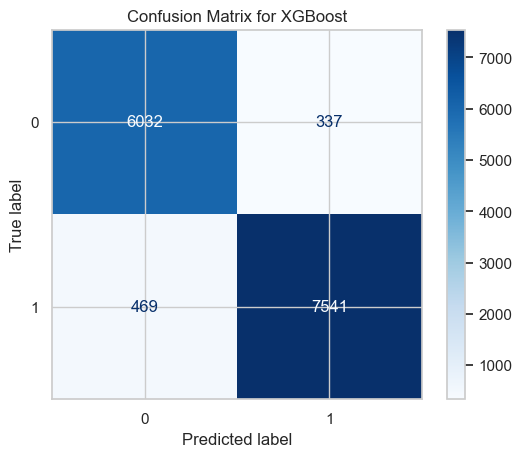

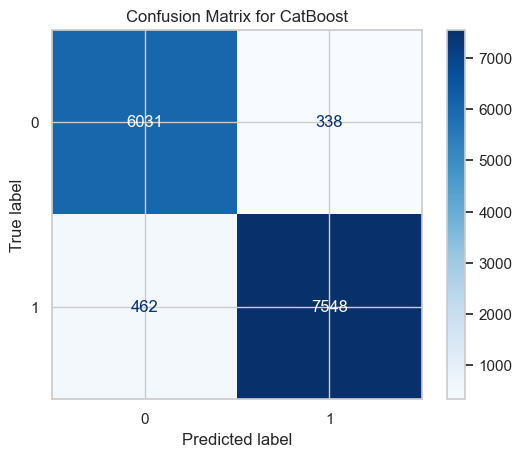

In [42]:
for res in results:
    name = res["Model"]
    y_pred = res["y_pred"]

    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
    disp.ax_.set_title(f"Confusion Matrix for {name}")
    plt.show()

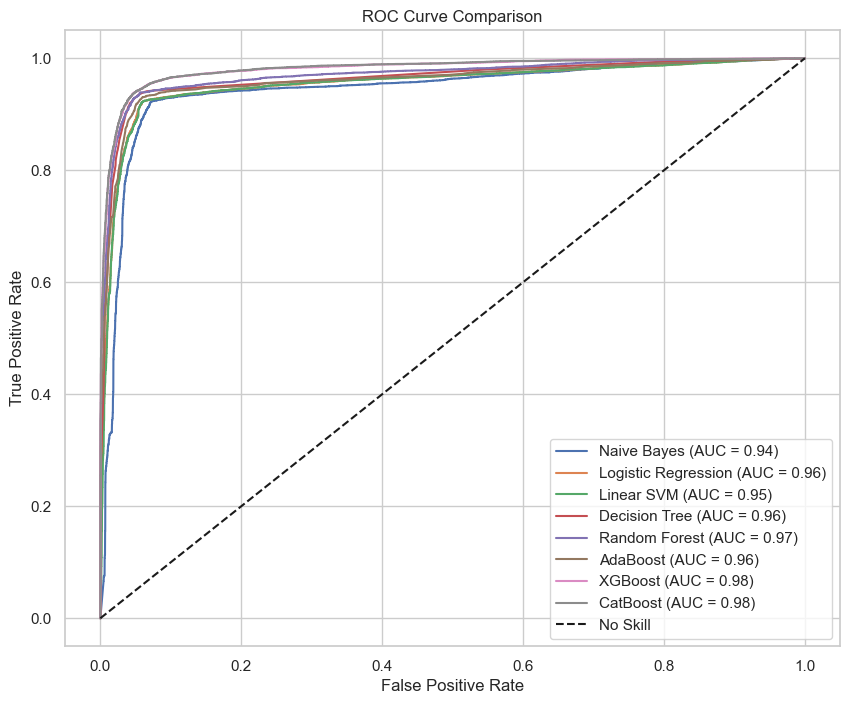

In [43]:
plt.figure(figsize=(10, 8))

for res in results:
    name = res["Model"]
    y_prob = res.get("y_prob")

    if y_prob is None:
        continue

    try:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {res['ROC AUC']:.2f})")
    except Exception as e:
        print(f"Skipping {name} for ROC curve: {e}")
        continue

plt.plot([0, 1], [0, 1], "k--", label="No Skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

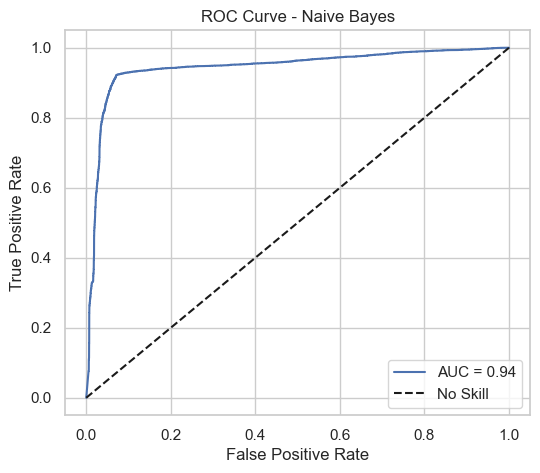

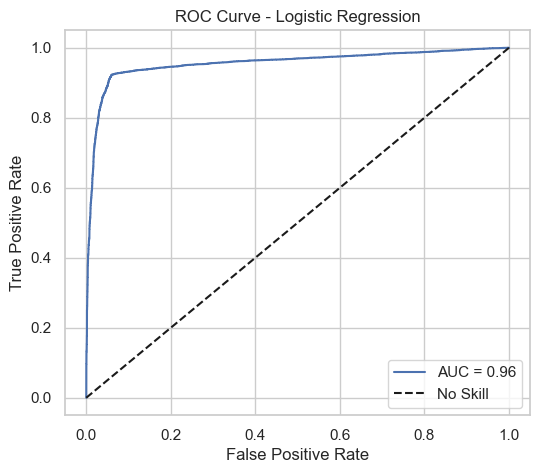

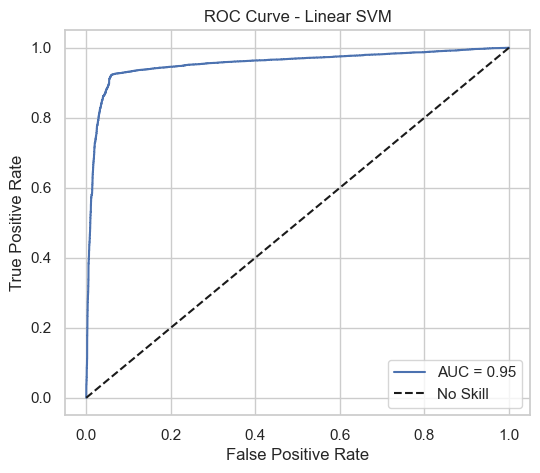

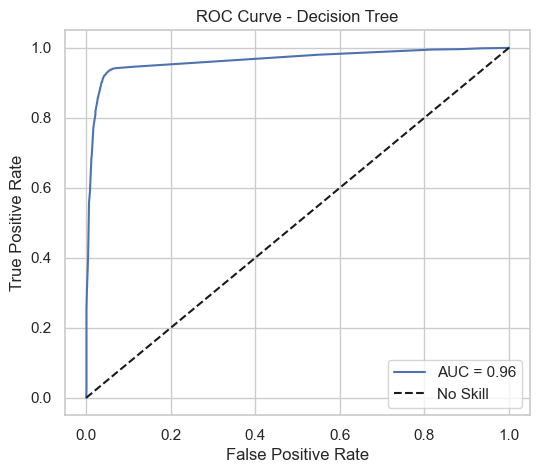

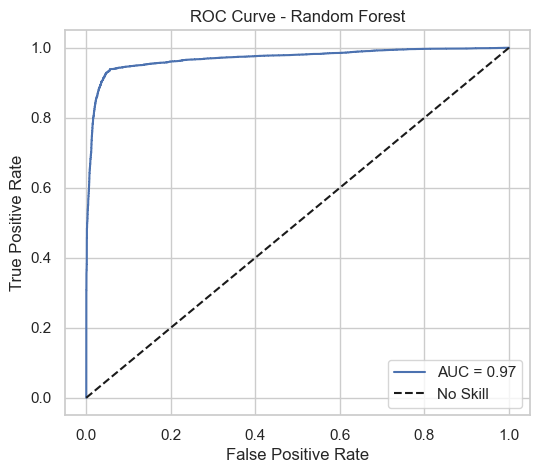

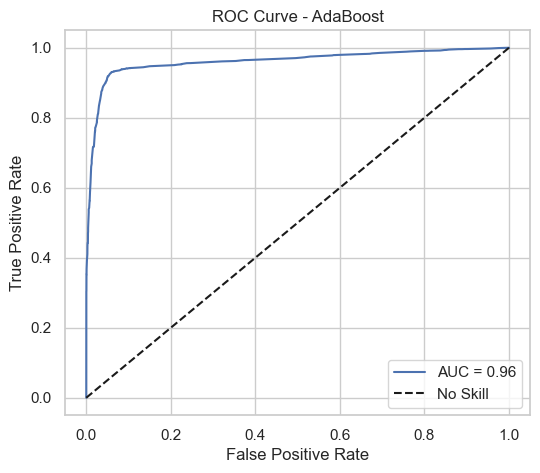

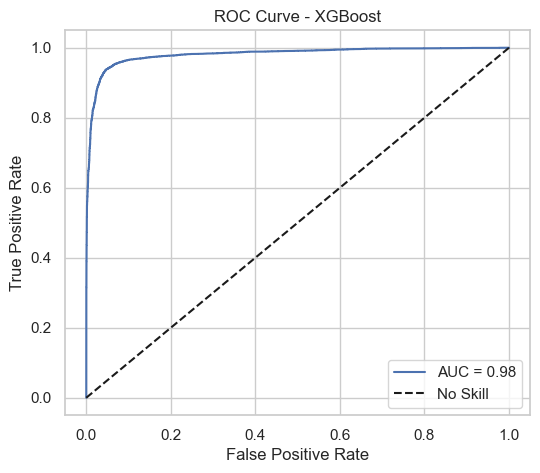

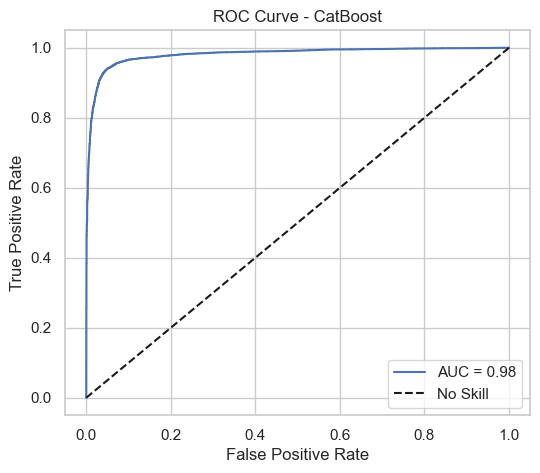

In [44]:
for res in results:
    name = res["Model"]
    y_prob = res.get("y_prob")

    if y_prob is None:
        continue

    try:
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"AUC = {res['ROC AUC']:.2f}")
        plt.plot([0, 1], [0, 1], "k--", label="No Skill")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name}")
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Skipping {name} for ROC curve: {e}")
        continue

In [45]:
auc_scores_df = results_df[['Model', 'ROC AUC']].copy()

display(auc_scores_df)

,Model,ROC AUC
0,Naive Bayes,0.943626
1,Logistic Regression,0.955278
2,Linear SVM,0.954391
3,Decision Tree,0.964499
4,Random Forest,0.970465
5,AdaBoost,0.961157
6,XGBoost,0.980799
7,CatBoost,0.981142


In [46]:
auc_scores_df.to_excel('model_roc_auc_scores.xlsx', index=False)

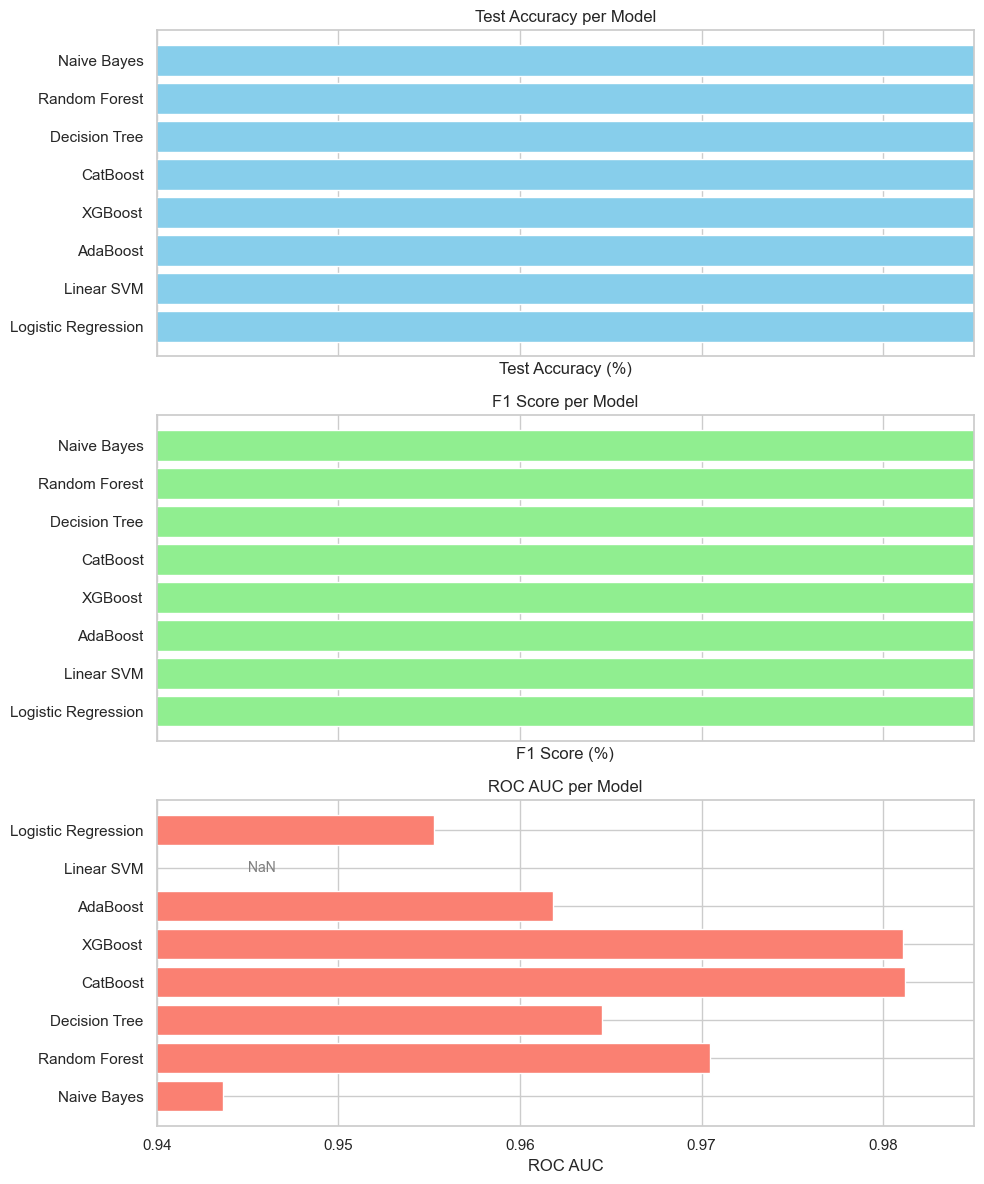

In [47]:
models = [
    "Logistic Regression", "Linear SVM", "AdaBoost",
    "XGBoost", "CatBoost", "Decision Tree", "Random Forest", "Naive Bayes"
]

test_accuracy = [92.52, 92.09, 93.46, 94.38, 94.44, 93.95, 93.90, 92.10]
f1_score = [93.12, 92.69, 94.06, 94.92, 94.97, 94.50, 94.46, 92.78]
roc_auc = [0.955278, np.nan, 0.961807, 0.981079, 0.981218, 0.964499, 0.970465, 0.943626]

df = pd.DataFrame({
    "Model": models,
    "Test Accuracy": test_accuracy,
    "F1 Score": f1_score,
    "ROC AUC": roc_auc
})

fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Test Accuracy
ax[0].barh(models, test_accuracy, color='skyblue')
ax[0].set_title("Test Accuracy per Model")
ax[0].set_xlim(91, 95)
ax[0].set_xlabel("Test Accuracy (%)")

# F1 Score
ax[1].barh(models, f1_score, color='lightgreen')
ax[1].set_title("F1 Score per Model")
ax[1].set_xlim(91, 95)
ax[1].set_xlabel("F1 Score (%)")

# ROC AUC
roc_auc_clean = [val if not np.isnan(val) else 0 for val in roc_auc]
ax[2].barh(models, roc_auc_clean, color='salmon')
ax[2].set_title("ROC AUC per Model")
ax[2].set_xlim(0.94, 0.985)
ax[2].set_xlabel("ROC AUC")

# Annotasi NaN untuk SVM di ROC AUC
if np.isnan(roc_auc[1]):
    ax[2].text(0.945, 1, "NaN", va='center', ha='left', fontsize=10, color='gray')

plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

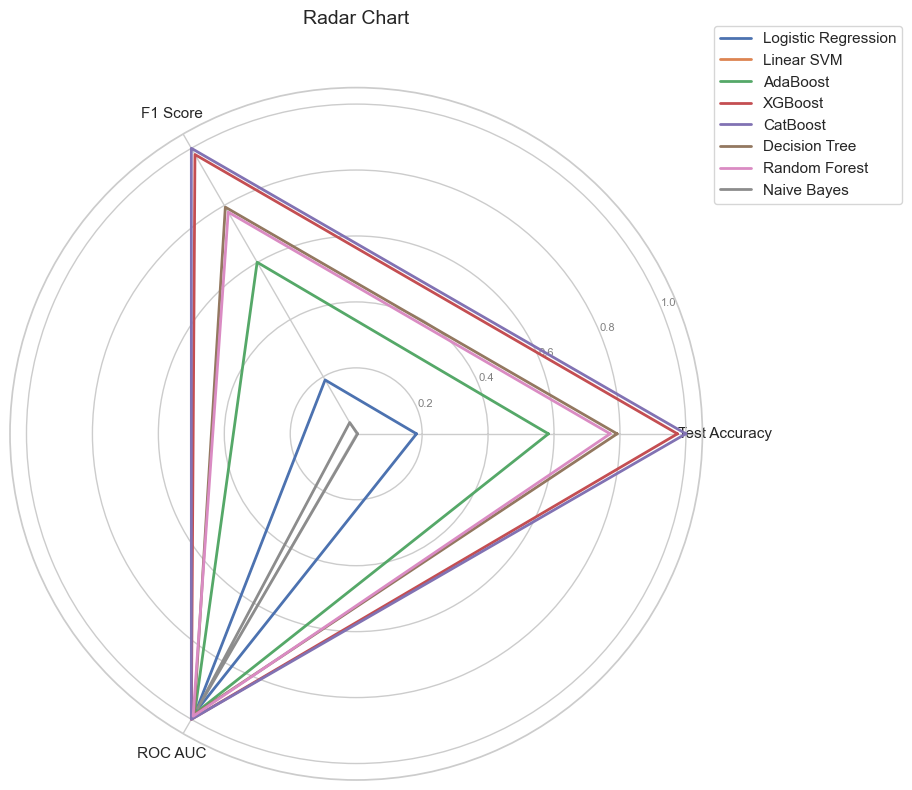

In [48]:
radar_df = pd.DataFrame({
    'Model': models,
    'Test Accuracy': test_accuracy,
    'F1 Score': f1_score,
    'ROC AUC': roc_auc_clean
})

normalized_df = radar_df.copy()
metrics = ['Test Accuracy', 'F1 Score', 'ROC AUC']
for metric in metrics:
    min_val = radar_df[metric].min()
    max_val = radar_df[metric].max()
    normalized_df[metric] = (radar_df[metric] - min_val) / (max_val - min_val)

categories = metrics
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(10, 8))
for i in range(len(normalized_df)):
    values = normalized_df.loc[i, categories].tolist()
    values += values[:1]
    plt.polar(angles, values, label=normalized_df.loc[i, 'Model'], linewidth=2)

plt.xticks(angles[:-1], categories)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=8)
plt.title("Radar Chart", size=14, y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

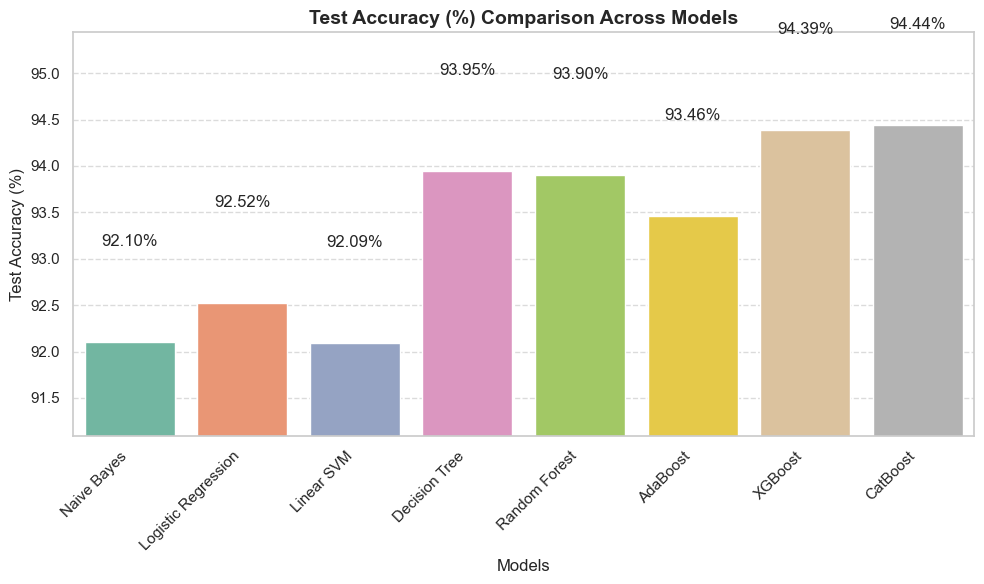

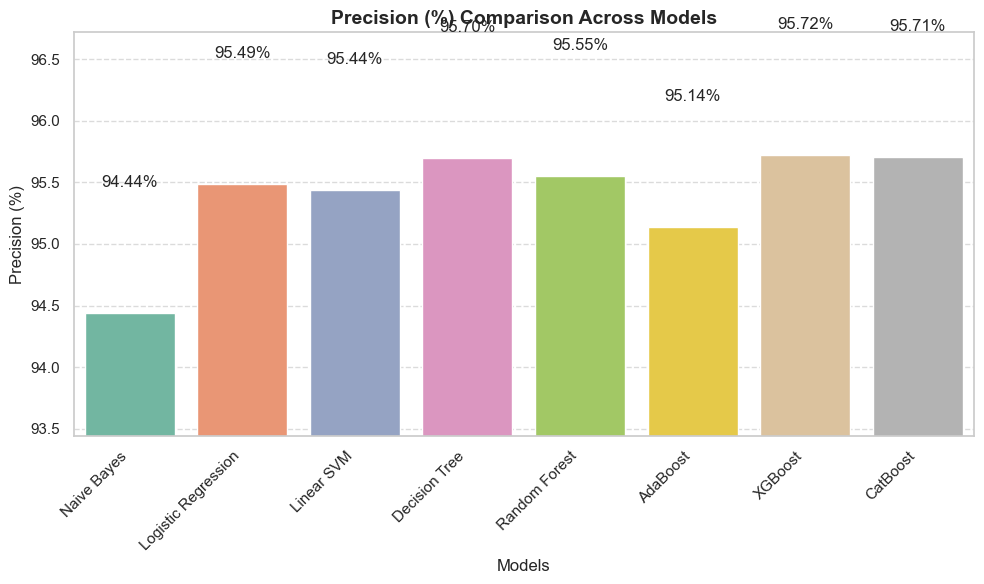

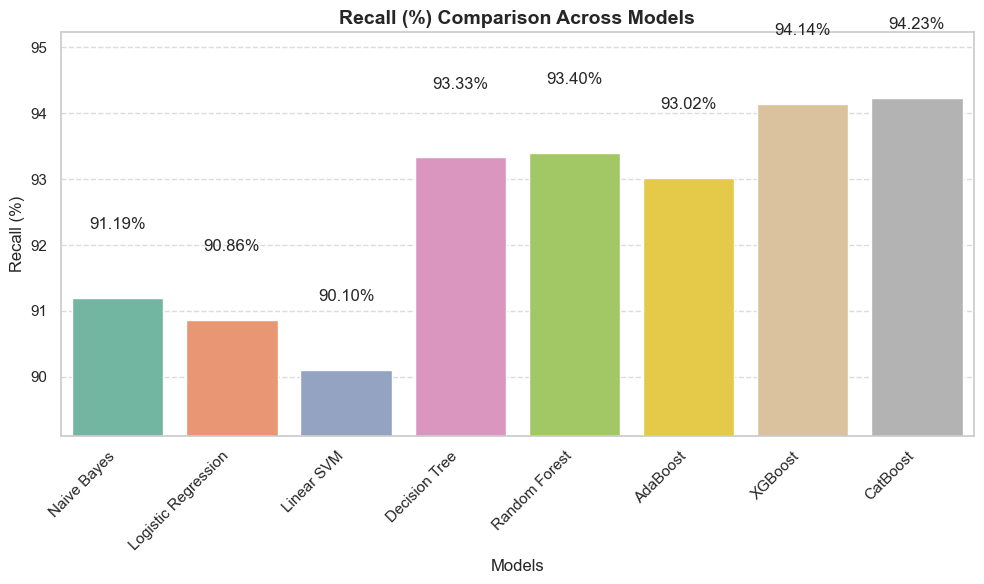

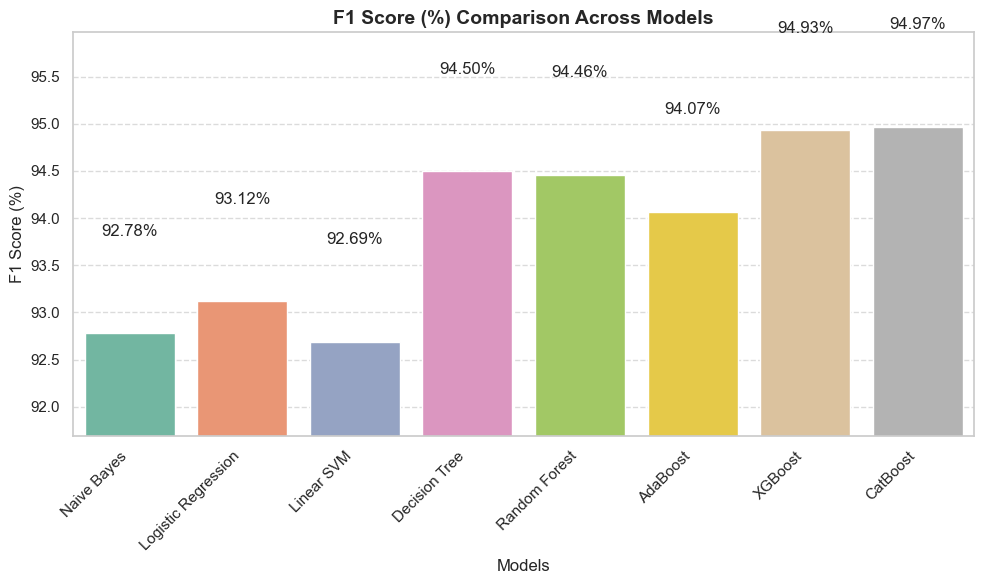

In [49]:
sns.set(style="whitegrid")

metrics = ["Test Accuracy (%)", "Precision (%)", "Recall (%)", "F1 Score (%)"]

for metric in metrics:
    plt.figure(figsize=(10, 6))
    # sorted_df = results_df.sort_values(by=metric, ascending=False)
    ax = sns.barplot(data=results_df, x="Model", y=metric, palette="Set2")

    plt.title(f"{metric} Comparison Across Models", fontsize=14, weight='bold')
    plt.ylabel(metric)
    plt.xlabel("Models")
    plt.ylim(results_df[metric].min() - 1, results_df[metric].max() + 1)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    for i, (x, y) in enumerate(zip(results_df["Model"], results_df[metric])):
        plt.text(i, y + 1, f"{y:.2f}%", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [ ]:
# pip freeze > local_requirements.txt

Note: you may need to restart the kernel to use updated packages.
